In [1]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import tkinter as tk
from scipy import signal
from scipy import ndimage
from math import ceil
import cv2
import ot as pot
import itertools
import matplotlib.patches as patches

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# PROJECT_PATH = os.getcwd()
sys.path.append(os.path.dirname(PROJECT_PATH))

from _prototypes.cell_remapping.src.remapping import pot_sliced_wasserstein, single_point_wasserstein, compute_centroid_remapping
from _prototypes.cell_remapping.src.wasserstein_distance import _get_ratemap_bucket_midpoints

unit_matcher_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(unit_matcher_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes


In [3]:
def _interpolate_matrix(matrix, new_size=(257,257), cv2_interpolation_method=cv2.INTER_CUBIC):
    '''
        Interpolate a matrix using cv2.INTER_LANCZOS4.
    '''
    return cv2.resize(matrix, dsize=new_size,
                      interpolation=cv2_interpolation_method)

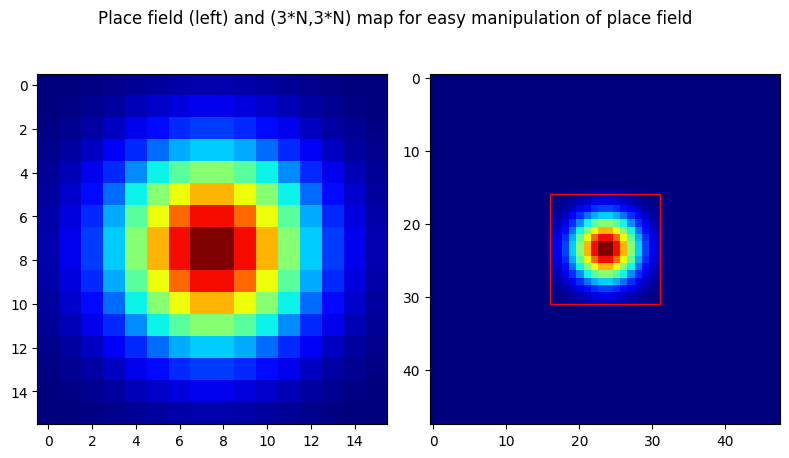

In [4]:
def make_single_field(N=16, stdev=10, shift_row=0, shift_col=0, custom_gauss=None):
    """
    N is kernel size
    """
    if custom_gauss is None:
        k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
        kernel = np.outer(k1d, k1d)
    else:
        kernel = custom_gauss
    single_field = np.zeros((N*3, N*3))
    single_field[N+ceil(N/2)+shift_row, N+ceil(N/2)+shift_col] = 1  
    row, col = np.where(single_field == 1)
    rowend = row[0]+ceil(N/2)
    colend = col[0]+ceil(N/2)
    if colend >= len(single_field):
        colend -= len(single_field)
        colinter = N - colend
    else:
        colinter = N
    if rowend >= len(single_field):
        rowend -= len(single_field)
        rowinter = N - rowend
    else:
        rowinter = N

    # if N % 2 == 0:
    #     single_field[row[0]-ceil(N/2):row[0]+ceil(N/2), col[0]-ceil(N/2):col[0]+ceil(N/2)] = kernel[:rowinter, :colinter]
    # else:
    #     single_field[row[0]-N//2:row[0]+ceil(N/2), col[0]-N//2:col[0]+ceil(N/2)] = kernel[:rowinter, :colinter]

    single_field[row[0]-ceil(N/2):row[0]+N//2, col[0]-ceil(N/2):col[0]+N//2] = kernel
    return single_field

N = 16
stdev = 3
single_field = make_single_field(N, stdev)
k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
kernel = np.outer(k1d, k1d)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,2,1)
ax.imshow(kernel, cmap='jet')
ax = plt.subplot(1,2,2)
ax.imshow(single_field, cmap='jet')
rect = patches.Rectangle((N, N), N-1, N-1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
fig.tight_layout()
fig.suptitle('Place field (left) and (3*N,3*N) map for easy manipulation of place field')
plt.show()



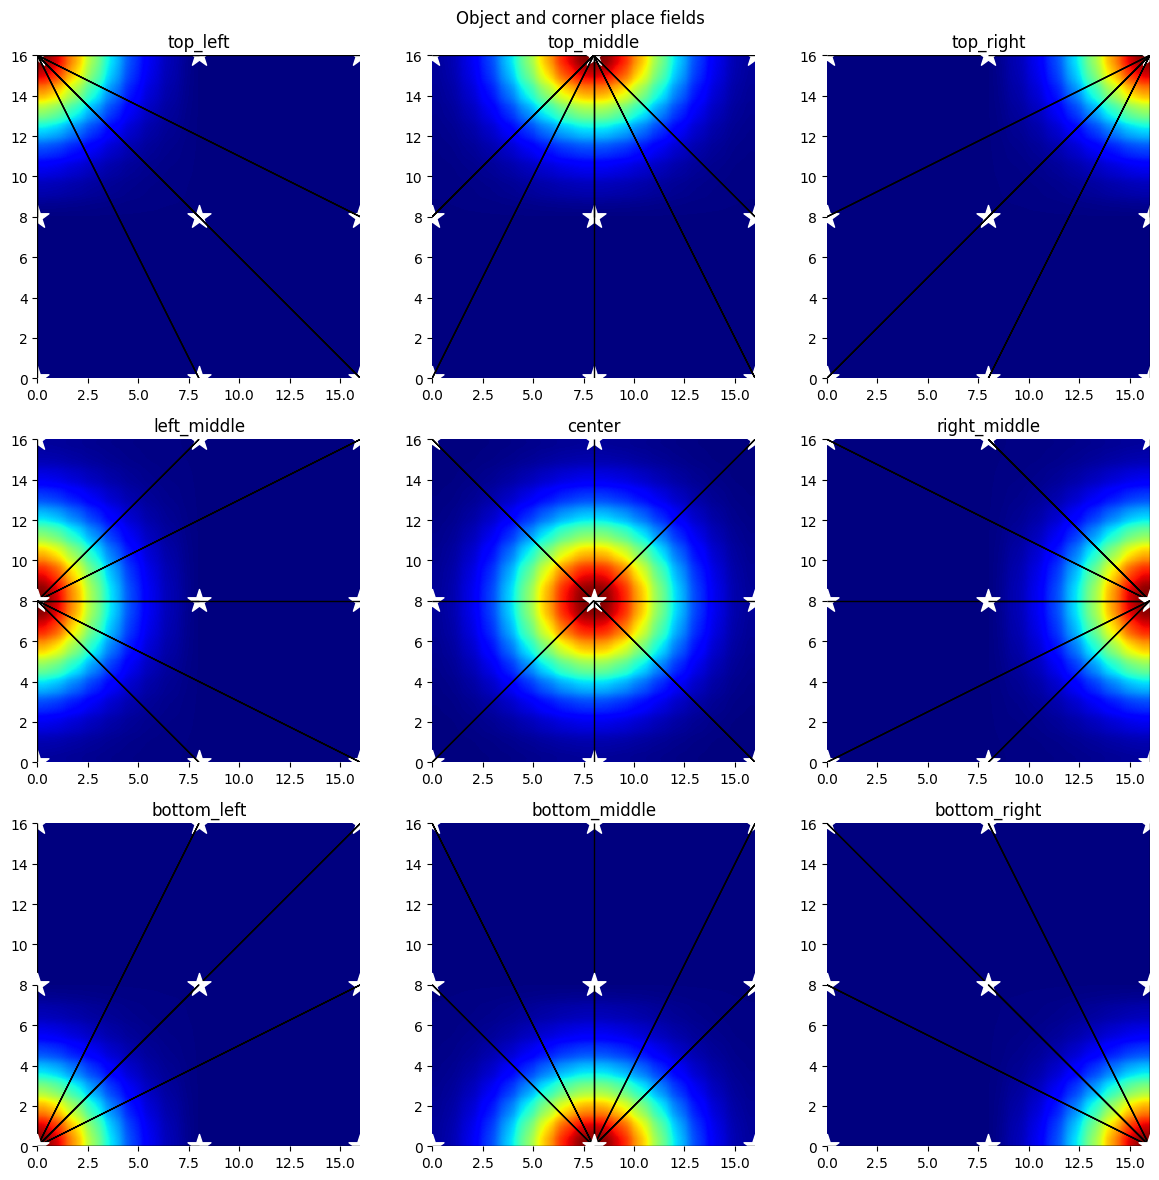

In [240]:
N = 17
stdev = 3
single_field = make_single_field(N, stdev)
top_left = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=-ceil(N/2))
top_middle = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=0)
top_right = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=ceil(N/2))
right_middle = make_single_field(N, stdev, shift_row=0, shift_col=ceil(N/2))
bottom_right = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=ceil(N/2))
bottom_middle = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=0)
bottom_left = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=-ceil(N/2))
left_middle = make_single_field(N, stdev, shift_row=0, shift_col=-ceil(N/2))

object_corner_fields = {
    'top_left': {'field': top_left[N:N+N,N:N+N], 'centroid': [0,N-1]},
    'top_middle': {'field': top_middle[N:N+N,N:N+N], 'centroid': [int(N/2),N-1]},
    'top_right': {'field': top_right[N:N+N,N:N+N], 'centroid': [N-1,N-1]},
    'right_middle': {'field': right_middle[N:N+N,N:N+N], 'centroid': [N-1,int(N/2)]},
    'bottom_right': {'field': bottom_right[N:N+N,N:N+N], 'centroid': [N-1,0]},
    'bottom_middle': {'field': bottom_middle[N:N+N,N:N+N], 'centroid': [int(N/2),0]},
    'bottom_left': {'field': bottom_left[N:N+N,N:N+N], 'centroid': [0,0]},
    'left_middle': {'field': left_middle[N:N+N,N:N+N], 'centroid': [0,int(N/2)]},
    'center': {'field': single_field[N:N+N,N:N+N], 'centroid': [int(N/2),int(N/2)]},
}

to_plot = ['top_left', 'top_middle', 'top_right', 'left_middle', 'center', 'right_middle', 'bottom_left', 'bottom_middle', 'bottom_right']

fig = plt.figure(figsize=(12,12))
axs = []
for i in range(1,10,1):
    ax = plt.subplot(3,3,i)
    true_pt = object_corner_fields[to_plot[i-1]]['centroid']

    # ax.scatter([0],[N-1],color='k')

    # vectors = []
    for j in range(1,10,1):
        pt = object_corner_fields[to_plot[j-1]]['centroid']
        ax.scatter([pt[0]], [pt[1]], c='white',s=300,marker='*')
        # ax.quiver([true_pt[0]], [true_pt[1]], [pt[0]], [pt[1]], units='xy')
        if i != j:
            # ax.quiver(*pt,[true_pt[0]-pt[0]],[true_pt[1]-pt[1]], scale=0.1, color='k', width=0.01)
            ax.arrow(pt[0], pt[1], true_pt[0]-pt[0], true_pt[1]-pt[1],color='k', head_width=0, head_length=0)

    ax.imshow(_interpolate_matrix(object_corner_fields[to_plot[i-1]]['field']), cmap='jet', extent=[0,N-1,0,N-1])
    axs.append(ax)
    ax.set_frame_on(False) 
    ax.set_title(str(to_plot[i-1]))

fig.suptitle('Object and corner place fields')
fig.tight_layout()
plt.show()

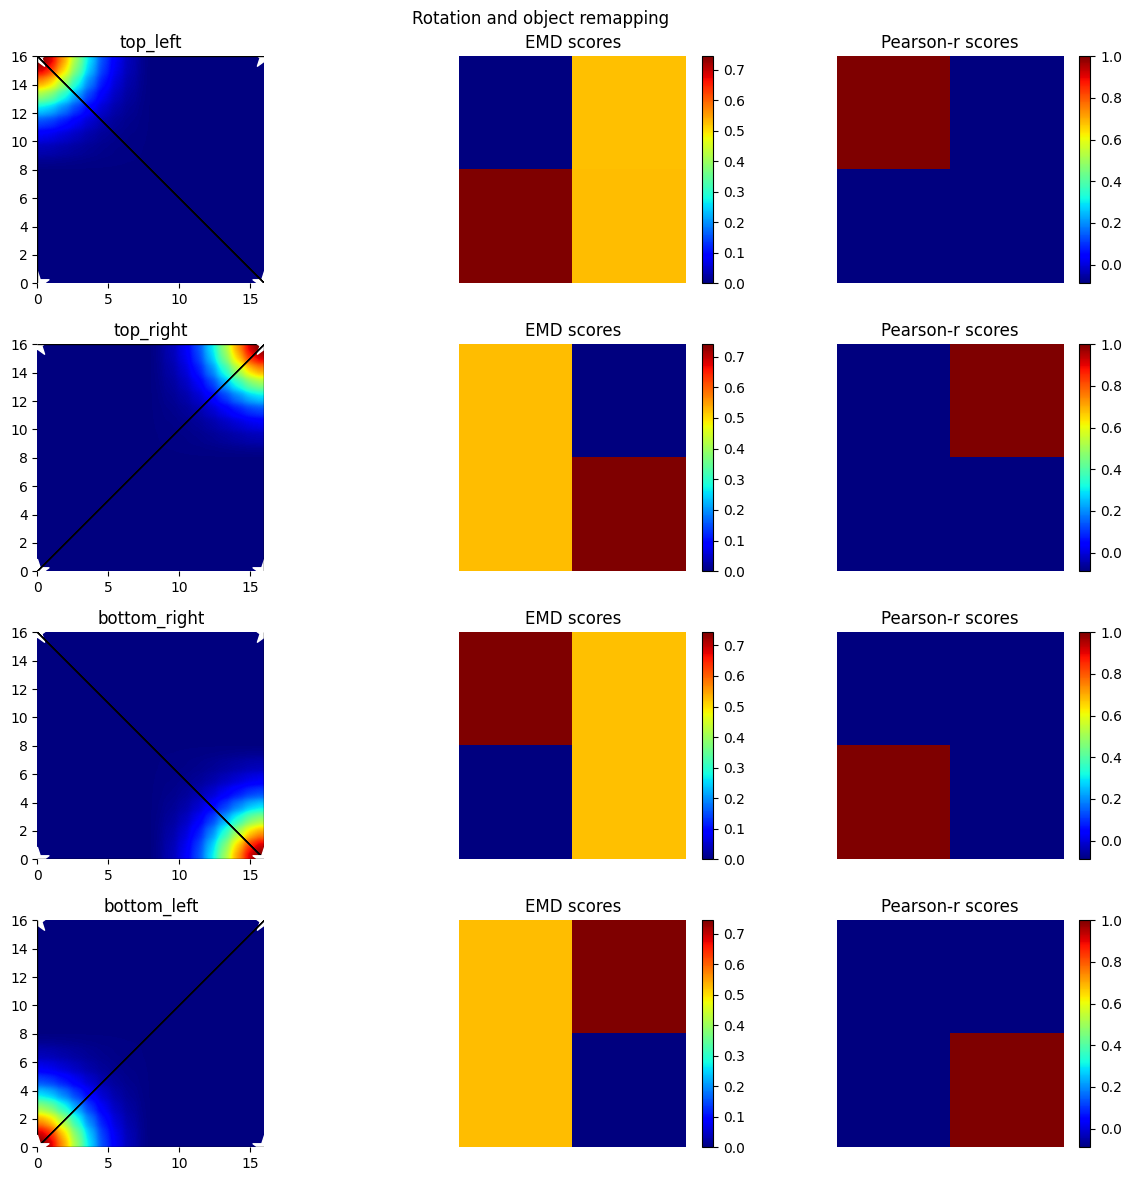

In [6]:

to_plot = ['top_left', 'top_right', 'bottom_right', 'bottom_left']

fig = plt.figure(figsize=(12,12))
axs = []
peg = object_corner_fields['top_left']
i = 1
for c in [1,4,7,10]:
    ax = plt.subplot(4,3,c)
    true_pt = object_corner_fields[to_plot[i-1]]['centroid']
    source_field = object_corner_fields[to_plot[i-1]]['field']
    emd_scores = np.zeros(4)
    pearson_scores = np.zeros(4)
    y, x = source_field.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: source_field[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    for j in range(1,5,1):
        pt = object_corner_fields[to_plot[j-1]]['centroid']
        field = object_corner_fields[to_plot[j-1]]['field']
        ax.scatter([pt[0]], [pt[1]], c='white',s=300,marker='*')
        # ax.quiver([true_pt[0]], [true_pt[1]], [pt[0]], [pt[1]], units='xy')
        if i != j:
            # ax.quiver(*pt,[true_pt[0]-pt[0]],[true_pt[1]-pt[1]], scale=0.1, color='k', width=0.01)
            ax.arrow(pt[0], pt[1], true_pt[0]-pt[0], true_pt[1]-pt[1],color='k', head_width=0, head_length=0)
        
        target_weights = np.array(list(map(lambda x: field[x[0],x[1]], buckets)))
        target_weights = target_weights / np.sum(target_weights)

        emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
        emd_scores[j-1] = emd
        # emd = pot.wass
        r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
        pearson_scores[j-1] = r

    emd_scores = emd_scores.reshape((2,2))
    pearson_scores = pearson_scores.reshape((2,2))

    ax.imshow(_interpolate_matrix(object_corner_fields[to_plot[i-1]]['field']), cmap='jet', extent=[0,N-1,0,N-1])
    axs.append(ax)
    ax.set_frame_on(False) 
    ax.set_title(str(to_plot[i-1]))

    ax = plt.subplot(4,3,c+1)
    im = ax.imshow(emd_scores, cmap='jet', aspect='equal')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('EMD scores')
    ax.axis('off')

    ax = plt.subplot(4,3,c+2)
    im = ax.imshow(pearson_scores, cmap='jet', aspect='equal')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('Pearson-r scores')
    ax.axis('off')

    # ax.imshow(pearson_scores)

    i += 1

fig.suptitle('Rotation and object remapping')
fig.tight_layout()
plt.show()

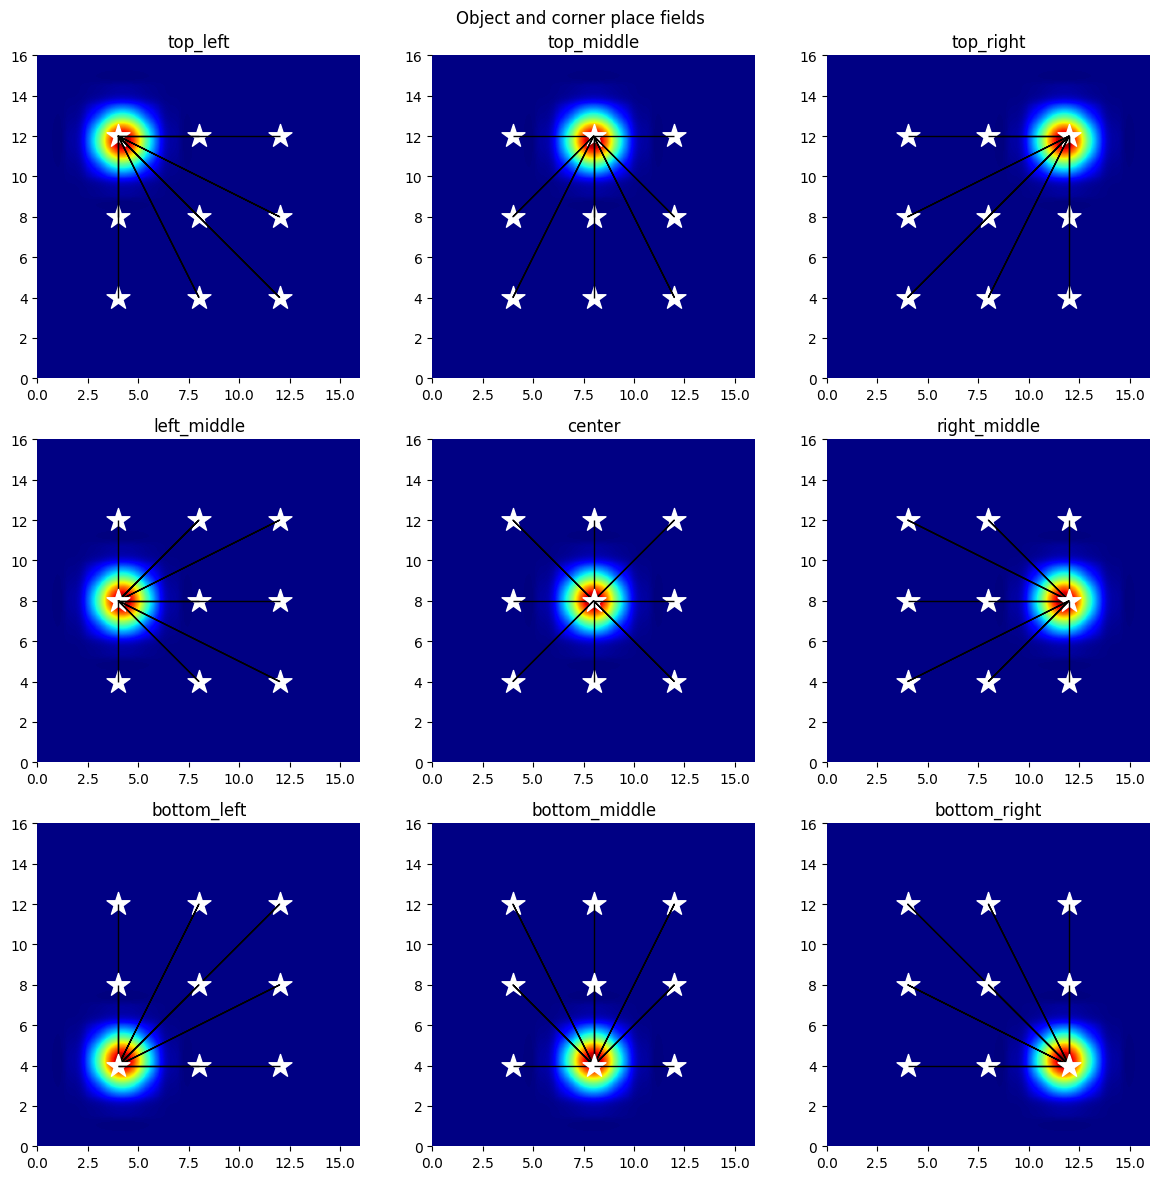

In [7]:
N = 17
stdev = 1
single_field = make_single_field(N, stdev)
top_left = make_single_field(N, stdev, shift_row=-ceil(N/2)+ceil(N/4), shift_col=-ceil(N/2)+ ceil(N/4))
top_middle = make_single_field(N, stdev, shift_row=-ceil(N/2)+ceil(N/4), shift_col=0)
top_right = make_single_field(N, stdev, shift_row=-ceil(N/2)+ceil(N/4), shift_col=ceil(N/2)-ceil(N/4))
right_middle = make_single_field(N, stdev, shift_row=0, shift_col=ceil(N/2)-ceil(N/4))
bottom_right = make_single_field(N, stdev, shift_row=ceil(N/2)-ceil(N/4), shift_col=ceil(N/2)-ceil(N/4))
bottom_middle = make_single_field(N, stdev, shift_row=ceil(N/2)-ceil(N/4), shift_col=0)
bottom_left = make_single_field(N, stdev, shift_row=ceil(N/2)-ceil(N/4), shift_col=-ceil(N/2)+ceil(N/4))
left_middle = make_single_field(N, stdev, shift_row=0, shift_col=-ceil(N/2)+ceil(N/4))

object_corner_fields = {
    'top_left': {'field': top_left[N:N+N,N:N+N], 'centroid': [0+int(N/4),N-1-int(N/4)]},
    'top_middle': {'field': top_middle[N:N+N,N:N+N], 'centroid': [int(N/2),N-1-int(N/4)]},
    'top_right': {'field': top_right[N:N+N,N:N+N], 'centroid': [N-1-int(N/4),N-1-int(N/4)]},
    'right_middle': {'field': right_middle[N:N+N,N:N+N], 'centroid': [N-1-int(N/4),int(N/2)]},
    'bottom_right': {'field': bottom_right[N:N+N,N:N+N], 'centroid': [N-1-int(N/4),0+int(N/4)]},
    'bottom_middle': {'field': bottom_middle[N:N+N,N:N+N], 'centroid': [int(N/2),0+int(N/4)]},
    'bottom_left': {'field': bottom_left[N:N+N,N:N+N], 'centroid': [0+int(N/4),0+int(N/4)]},
    'left_middle': {'field': left_middle[N:N+N,N:N+N], 'centroid': [0+int(N/4),int(N/2)]},
    'center': {'field': single_field[N:N+N,N:N+N], 'centroid': [int(N/2),int(N/2)]},
}

# object_corner_fields = {
#     'top_left': {'field': top_left[N:N+N,N:N+N], 'centroid': [N-1-int(N/4),int(N/4)]},
#     'top_middle': {'field': top_middle[N:N+N,N:N+N], 'centroid': [int(N/2),int(N/4)]},
#     'top_right': {'field': top_right[N:N+N,N:N+N], 'centroid': [int(N/4),int(N/4)]},
#     'right_middle': {'field': right_middle[N:N+N,N:N+N], 'centroid': [N-1-int(N/4),int(N/2)]},
#     'bottom_right': {'field': bottom_right[N:N+N,N:N+N], 'centroid': [N-1-int(N/4),N-1-int(N/4)]},
#     'bottom_middle': {'field': bottom_middle[N:N+N,N:N+N], 'centroid': [N-1-int(N/2),N-1-int(N/4)]},
#     'bottom_left': {'field': bottom_left[N:N+N,N:N+N], 'centroid': [int(N/4),N-1-int(N/4)]},
#     'left_middle': {'field': left_middle[N:N+N,N:N+N], 'centroid': [0+int(N/4),int(N/2)]},
#     'center': {'field': single_field[N:N+N,N:N+N], 'centroid': [int(N/2),int(N/2)]},
# }

to_plot = ['top_left', 'top_middle', 'top_right', 'left_middle', 'center', 'right_middle', 'bottom_left', 'bottom_middle', 'bottom_right']

fig = plt.figure(figsize=(12,12))
axs = []
for i in range(1,10,1):
    ax = plt.subplot(3,3,i)
    true_pt = object_corner_fields[to_plot[i-1]]['centroid']

    # ax.scatter([0],[N-1],color='k')

    # vectors = []
    for j in range(1,10,1):
        pt = object_corner_fields[to_plot[j-1]]['centroid']
        ax.scatter([pt[0]], [pt[1]], c='white',s=300,marker='*')
        # ax.quiver([true_pt[0]], [true_pt[1]], [pt[0]], [pt[1]], units='xy')
        if i != j:
            # ax.quiver(*pt,[true_pt[0]-pt[0]],[true_pt[1]-pt[1]], scale=0.1, color='k', width=0.01)
            ax.arrow(pt[0], pt[1], true_pt[0]-pt[0], true_pt[1]-pt[1],color='k', head_width=0, head_length=0)
    ax.imshow(_interpolate_matrix(object_corner_fields[to_plot[i-1]]['field']), cmap='jet', extent=[0,N-1,0,N-1])
    axs.append(ax)
    ax.set_title(str(to_plot[i-1]))
    ax.set_frame_on(False) 

fig.suptitle('Object and corner place fields')
fig.tight_layout()
plt.show()

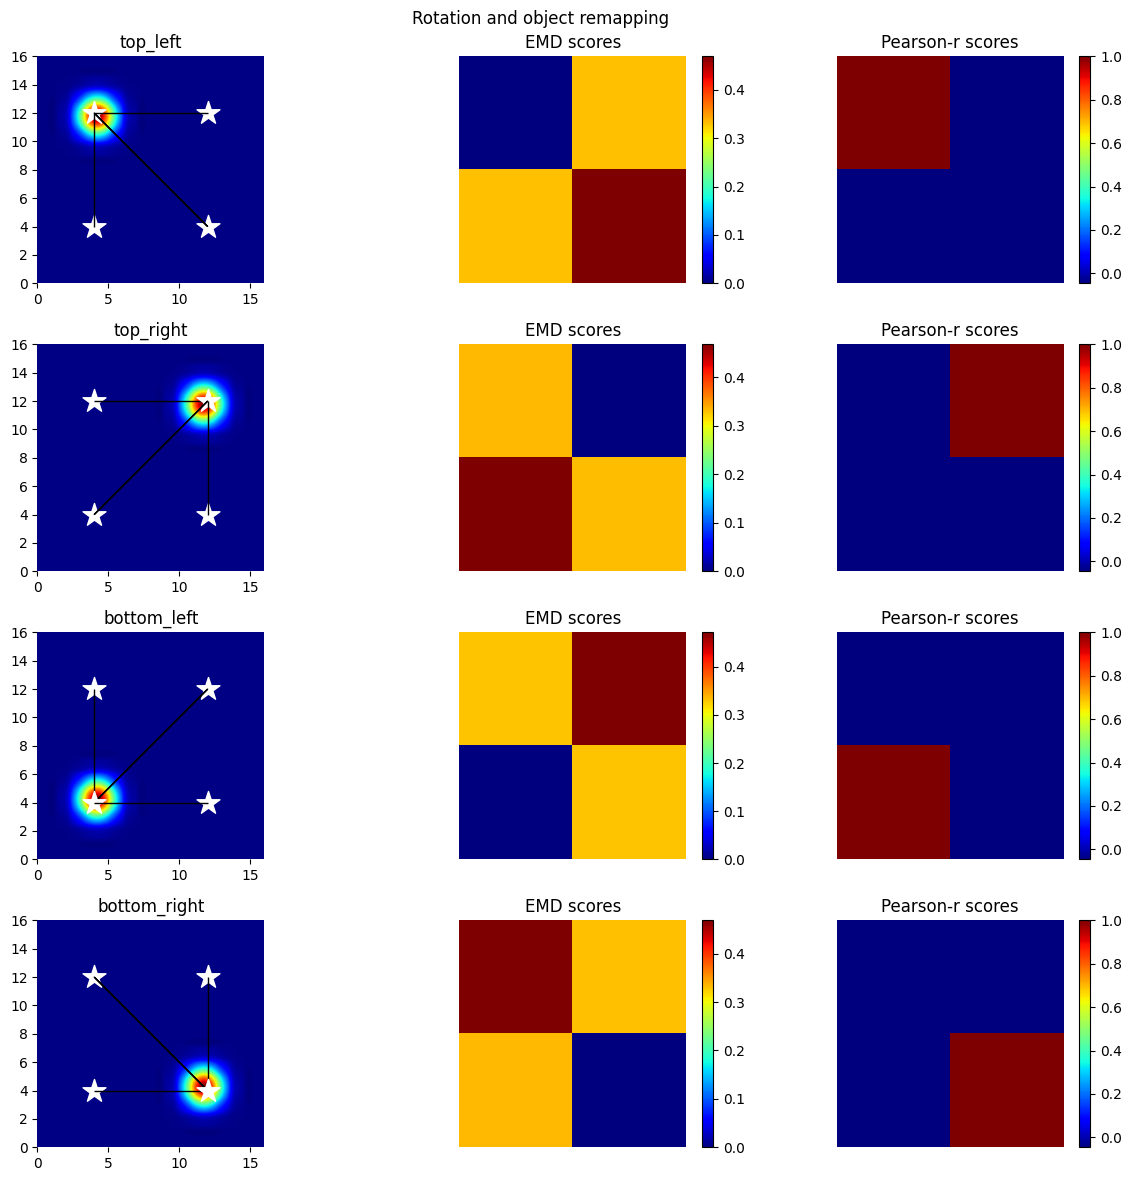

In [8]:

to_plot = ['top_left', 'top_right', 'bottom_left', 'bottom_right']

fig = plt.figure(figsize=(12,12))
axs = []
peg = object_corner_fields['top_left']
i = 1
for c in [1,4,7,10]:
    ax = plt.subplot(4,3,c)
    true_pt = object_corner_fields[to_plot[i-1]]['centroid']
    source_field = object_corner_fields[to_plot[i-1]]['field']
    emd_scores = np.zeros(4)
    pearson_scores = np.zeros(4)
    y, x = source_field.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: source_field[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    for j in range(1,5,1):
        pt = object_corner_fields[to_plot[j-1]]['centroid']
        field = object_corner_fields[to_plot[j-1]]['field']
        ax.scatter([pt[0]], [pt[1]], c='white',s=300,marker='*')
        # ax.quiver([true_pt[0]], [true_pt[1]], [pt[0]], [pt[1]], units='xy')
        if i != j:
            # ax.quiver(*pt,[true_pt[0]-pt[0]],[true_pt[1]-pt[1]], scale=0.1, color='k', width=0.01)
            ax.arrow(pt[0], pt[1], true_pt[0]-pt[0], true_pt[1]-pt[1],color='k', head_width=0, head_length=0)
        
        target_weights = np.array(list(map(lambda x: field[x[0],x[1]], buckets)))
        target_weights = target_weights / np.sum(target_weights)

        emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
        emd_scores[j-1] = emd
        # emd = pot.wass
        r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
        pearson_scores[j-1] = r

    emd_scores = emd_scores.reshape((2,2))
    pearson_scores = pearson_scores.reshape((2,2))

    ax.imshow(_interpolate_matrix(object_corner_fields[to_plot[i-1]]['field']), cmap='jet', extent=[0,N-1,0,N-1])
    axs.append(ax)
    ax.set_frame_on(False) 
    ax.set_title(str(to_plot[i-1]))

    ax = plt.subplot(4,3,c+1)
    im = ax.imshow(emd_scores, cmap='jet', aspect='equal')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('EMD scores')
    ax.axis('off')

    ax = plt.subplot(4,3,c+2)
    im = ax.imshow(pearson_scores, cmap='jet', aspect='equal')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('Pearson-r scores')
    ax.axis('off')

    # ax.imshow(pearson_scores)

    i += 1

fig.suptitle('Rotation and object remapping')
fig.tight_layout()
plt.show()

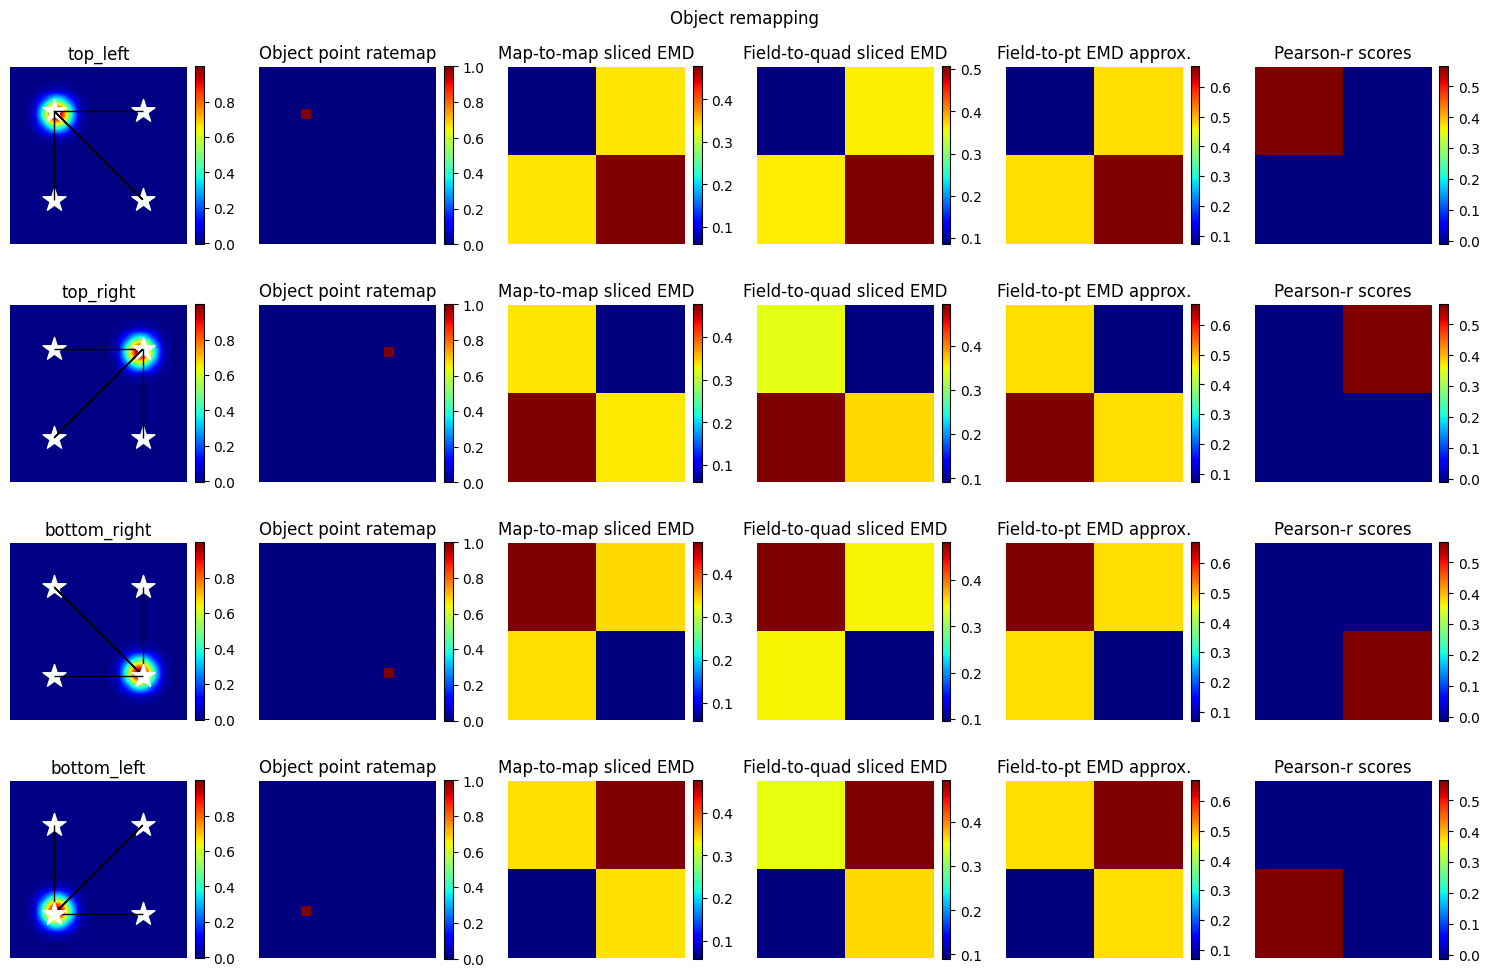

In [11]:

to_plot = ['top_left', 'top_right', 'bottom_right', 'bottom_left']
to_plot_idx = [[0,0],[0,1],[1,1],[1,0]]
to_plot_quads = [[np.arange(0,int(N/2),1),np.arange(0,int(N/2),1)],
                 [np.arange(0,int(N/2),1),np.arange(int(N/2),N,1)],
                 [np.arange(int(N/2),N,1),np.arange(int(N/2),N,1)],
                [np.arange(int(N/2),N,1),np.arange(0,int(N/2),1)],
]

def _fill_quad_pos(row, col, arr):
    arr[row, col] = 1

fig = plt.figure(figsize=(15,10))
axs = []
i = 1
for c in [1,7,13,19]:
    ax = plt.subplot(4,6,c)
    ax.axis('off')
    true_pt = object_corner_fields[to_plot[i-1]]['centroid']
    source_field = object_corner_fields[to_plot[i-1]]['field']
    emd_scores = np.zeros((2,2))
    emd_scores_to_pt = np.zeros((2,2))
    pearson_scores = np.zeros((2,2))
    emd_scores_quadrant = np.zeros((2,2))
    y, x = source_field.shape
    source_field = np.zeros(source_field.shape)
    source_field[N-1-true_pt[1],true_pt[0]] = 1

    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: source_field[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    for j in range(1,5,1):
        pt = object_corner_fields[to_plot[j-1]]['centroid']
        field = object_corner_fields[to_plot[j-1]]['field']
        ax.scatter([pt[0]], [pt[1]], c='white',s=300,marker='*')
        # ax.quiver([true_pt[0]], [true_pt[1]], [pt[0]], [pt[1]], units='xy')
        if i != j:
            # ax.quiver(*pt,[true_pt[0]-pt[0]],[true_pt[1]-pt[1]], scale=0.1, color='k', width=0.01)
            ax.arrow(pt[0], pt[1], true_pt[0]-pt[0], true_pt[1]-pt[1],color='k', head_width=0, head_length=0)
        # else:
        #     assert pt == true_pt
        #     field = np.zeros(field.shape)
        #     field[N-1-pt[1],pt[0]] = 1
        
        target_weights = np.array(list(map(lambda x: field[x[0],x[1]], buckets)))
        target_weights = target_weights / np.sum(target_weights)

        emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
        emd_scores[to_plot_idx[j-1][0], to_plot_idx[j-1][1]] = emd

        r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
        pearson_scores[to_plot_idx[j-1][0], to_plot_idx[j-1][1]] = r
        
        source_field_quad = np.zeros(source_field.shape)   
        list(map(lambda x: _fill_quad_pos(x[0],x[1], source_field_quad), list(itertools.product(to_plot_quads[i-1][0],to_plot_quads[i-1][1]))))
        source_field_quad = source_field_quad / np.sum(source_field_quad)

        rows, cols = np.where(source_field_quad > 0.01)
        source_ids = np.array([rows, cols]).T
        source_weights_quad = np.array(list(map(lambda x: source_field_quad[x[0], x[1]], source_ids)))
        source_weights_quad = source_weights_quad / np.sum(source_weights_quad)
        height_source_pts = height_bucket_midpoints[rows]
        width_source_pts = width_bucket_midpoints[cols]
        source_pts = np.array([height_source_pts, width_source_pts]).T

        rows, cols = np.where(field > 0.01)
        target_ids = np.array([rows, cols]).T
        target_weights = np.array(list(map(lambda x: field[x[0], x[1]], target_ids)))
        target_weights = target_weights / np.sum(target_weights)
        height_target_pts = height_bucket_midpoints[rows]
        width_target_pts = width_bucket_midpoints[cols]
        target_pts = np.array([height_target_pts, width_target_pts]).T
            
        emd = pot_sliced_wasserstein(source_pts, target_pts, source_weights_quad, target_weights, n_projections=10**4)
        emd_scores_quadrant[to_plot_idx[j-1][0], to_plot_idx[j-1][1]] = emd

        emd = single_point_wasserstein([N-1-true_pt[1], true_pt[0]], field, ([1],[1]))
        emd_scores_to_pt[to_plot_idx[j-1][0], to_plot_idx[j-1][1]] = emd

        # if i == j:
        #     baseEmd = emd
        # emd = pot.wass

    # emd_scores = emd_scores.reshape((2,2))
    # pearson_scores = pearson_scores.reshape((2,2))
    # emd_scores_to_pt = emd_scores_to_pt.reshape((2,2)) - baseEmd

    im = ax.imshow(_interpolate_matrix(object_corner_fields[to_plot[i-1]]['field']), cmap='jet', extent=[0,N-1,0,N-1])
    axs.append(ax)
    # ax.set_frame_on(False) 
    ax.set_title(str(to_plot[i-1]))
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)

    ax = plt.subplot(4,6,c+1)
    im = ax.imshow(source_field, aspect='equal', extent=[0,N-1,0,N-1], cmap='jet')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('Object-point ratemap')
    ax.axis('off')

    ax = plt.subplot(4,6,c+2)
    im = ax.imshow(emd_scores, cmap='jet', aspect='equal')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('Map-to-map sliced EMD')
    ax.axis('off')

    ax = plt.subplot(4,6,c+3)
    im = ax.imshow(emd_scores_quadrant, cmap='jet', aspect='equal')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('Field-to-quad sliced EMD')
    ax.axis('off')

    ax = plt.subplot(4,6,c+4)
    im = ax.imshow(emd_scores_to_pt, cmap='jet', aspect='equal')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('Field-to-pt EMD approx.')
    ax.axis('off')

    ax = plt.subplot(4,6,c+5)
    im = ax.imshow(pearson_scores, cmap='jet', aspect='equal')
    fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('Pearson-r scores')
    ax.axis('off')

    # ax.imshow(pearson_scores)

    i += 1

fig.suptitle('Object remapping')
fig.tight_layout()
plt.show()

In [209]:
import cv2

def _gkern(kernlen: int, std: int) -> np.ndarray:

    '''
        Returns a 2D Gaussian kernel array.

        Params:
            kernlen, std (int):
                Kernel length and standard deviation

        Returns:
            np.ndarray:
                gkern2d
    '''

    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d


# Taken from https://stackoverflow.com/questions/59144828/opencv-getting-all-blob-pixels
#public
def map_blobs(ratemap, **kwargs):

    '''
        Segments and labels firing fields in ratemap.

        Params:
            ratemap (np.ndarray):
                Array encoding neuron spike events in 2D space based on where
                the subject walked during experiment.

        Returns:
            tuple:
                image, n_labels, labels, centroids
            --------
            image (np.ndarray):
                Semi-processed image used for blob detection
            n_labels (np.ndarray):
                Array of blob numbers / ID's
            labels (np.ndarray):
                Segmented ratemap with each blob labelled
            centroids (np.ndarray):
                Array of coordinates for each blobs weighted centroid.
            field_sizes (list):
                List of size of each field as a percentage of map coverage
    '''

    # Create kernel for convolutional smoothing
    kernel = _gkern(26, 3)

    ratemap_copy = np.copy(ratemap)

    # Compute a 'low_noise' threshold where anything below the 10th percentile activity is removed
    low_noise = np.mean(ratemap_copy[ratemap_copy <= np.percentile(ratemap_copy, 20)])
    ratemap_copy[ratemap_copy <= np.percentile(ratemap_copy, 90)] = low_noise

    # Initial segmentation into blobs
    image = np.array(ratemap_copy * 255, dtype = np.uint8)
    thresh, blobs = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(blobs, connectivity=4)

    # Filter through each blob, and remove any blob smaller than some threshold.
    for i in range(1, n_labels):
        num_pix = len(np.where(labels==i)[0])
        if num_pix <= (blobs.size * 0.01):
            blobs[np.where(labels==i)] = 0

    # Once smaller blobs are removed, re-smooth, and re-normalize image
    image[np.where(blobs == 0)] = 0
    image = image / max(image.flatten())
    image = cv2.filter2D(image,-1,kernel)
    image = image / max(image.flatten())
    image_2 = np.array(image * 255, dtype = np.uint8)

    # Second round of segmentation to acquire more clean and accurate blobs from pre-preocessed image
    thresh, blobs = cv2.threshold(image_2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(blobs, connectivity=4)

    # Flip centroids to follow (x,y) convention
    if len(centroids) > 0:
        centroids = centroids[1:]
        centroids = np.fliplr(centroids)

    field_sizes = []
    for i in range(1, n_labels):
        field_sizes.append(( len(np.where(labels==i)[0]) / len(image_2.flatten()) ) * 100)

    map_blobs_dict = {'image': image, 'n_labels': n_labels, 'centroids': centroids, 'field_sizes': field_sizes}

    return image, n_labels, labels, centroids, field_sizes



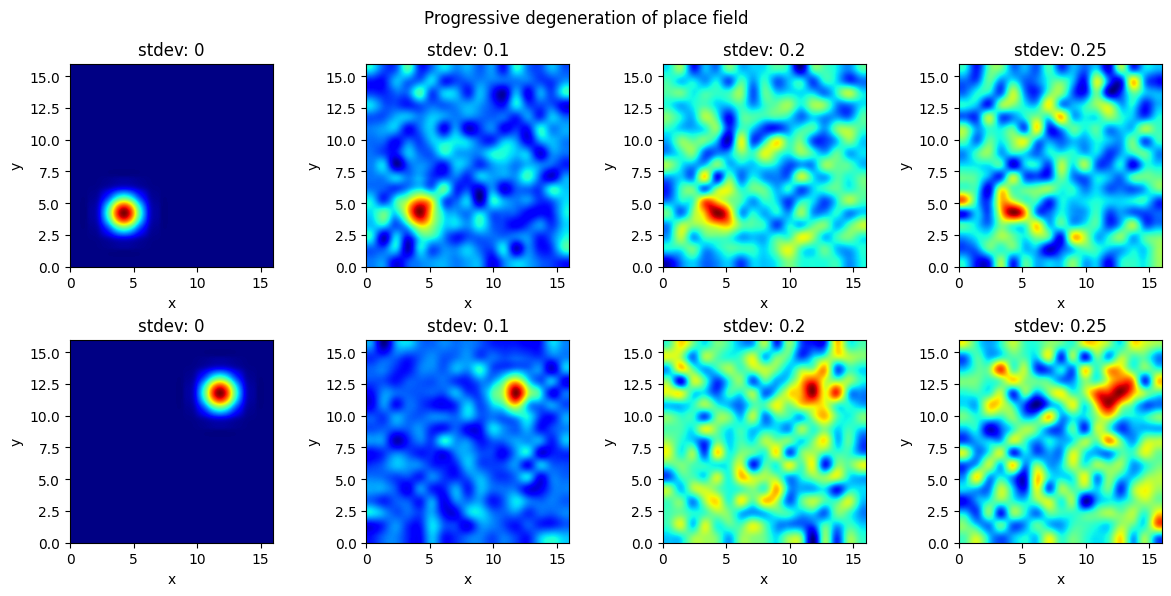

0


In [232]:
np.random.seed(0)
left = object_corner_fields['bottom_left']['field']
right = object_corner_fields['top_right']['field']

use_plot = [0,0.1,0.2,0.25]

fig = plt.figure(figsize=(12,6))
for i in range(0,4,1):
    ax = plt.subplot(2,4,i+1)
    ax.imshow(_interpolate_matrix(left+np.random.normal(0,use_plot[i],(N,N))), cmap='jet', extent=[0,N-1,0,N-1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('stdev: ' + str(use_plot[i]))
for j in range(4,8,1):
    ax = plt.subplot(2,4,j+1)
    ax.imshow(_interpolate_matrix(right+np.random.normal(0,use_plot[j-4],(N,N))), cmap='jet', extent=[0,N-1,0,N-1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('stdev: ' + str(use_plot[j-4]))

fig.suptitle('Progressive degeneration of place field')
fig.tight_layout()
plt.show()

emd_scores = []
pearson_scores = []
emd_field_scores = []

n_repeat = 1
for j in range(n_repeat):
    print(j)
    rep_emd_scores = []
    rep_pearson_scores = []
    rep_emd_field_scores = []
    for i in np.arange(0,0.25,0.001):

        source_field = left + np.random.normal(0,i,(N,N))
        field = right + np.random.normal(0,i,(N,N))
            
        s_labels = []
        t_labels = []

        while ((1 in np.unique(t_labels)) and (1 in np.unique(s_labels))) == False:
            source_field = left + np.random.normal(0,i,(N,N))
            field = right + np.random.normal(0,i,(N,N))

            s_image, n_s, s_labels, _, _ = map_blobs(source_field)
            t_image, n_t, t_labels, _, _ = map_blobs(field)

        assert len(np.unique(t_labels)) != 1
        y, x = source_field.shape
        height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
        buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
        source_weights = np.array(list(map(lambda x: source_field[x[0],x[1]], buckets)))
        source_weights = source_weights / np.sum(source_weights)
        coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
        target_weights = np.array(list(map(lambda x: field[x[0],x[1]], buckets)))
        target_weights = target_weights / np.sum(target_weights)

        emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
        rep_emd_scores.append(emd)

        r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
        rep_pearson_scores.append(r)

        rows, cols = np.where(s_labels != 0)
        source_ids = np.array([rows, cols]).T
        source_weights = np.array(list(map(lambda x: source_field[x[0], x[1]], source_ids)))
        source_weights = source_weights / np.sum(source_weights)
        height_source_pts = height_bucket_midpoints[rows]
        width_source_pts = width_bucket_midpoints[cols]
        source_pts = np.array([height_source_pts, width_source_pts]).T

        rows, cols = np.where(t_labels != 0)
        target_ids = np.array([rows, cols]).T
        target_weights = np.array(list(map(lambda x: field[x[0], x[1]], target_ids)))
        target_weights = target_weights / np.sum(target_weights)
        height_target_pts = height_bucket_midpoints[rows]
        width_target_pts = width_bucket_midpoints[cols]
        target_pts = np.array([height_target_pts, width_target_pts]).T
                    
        emd = pot_sliced_wasserstein(source_pts, target_pts, source_weights, target_weights, n_projections=10**4)
        rep_emd_field_scores.append(emd)

        # if emd > 5:
        #     plt.imshow(s_labels)
        #     plt.show()
        #     plt.imshow(t_labels)
        #     plt.show()
        #     plt.imshow(source_field)
        #     plt.show()
        #     plt.imshow(field)
        #     plt.show()

    emd_scores.append(rep_emd_scores)
    emd_field_scores.append(rep_emd_field_scores)
    pearson_scores.append(rep_pearson_scores)

emd_field_scores = np.array(emd_field_scores)
pearson_scores = np.array(pearson_scores)
emd_scores = np.array(emd_scores)


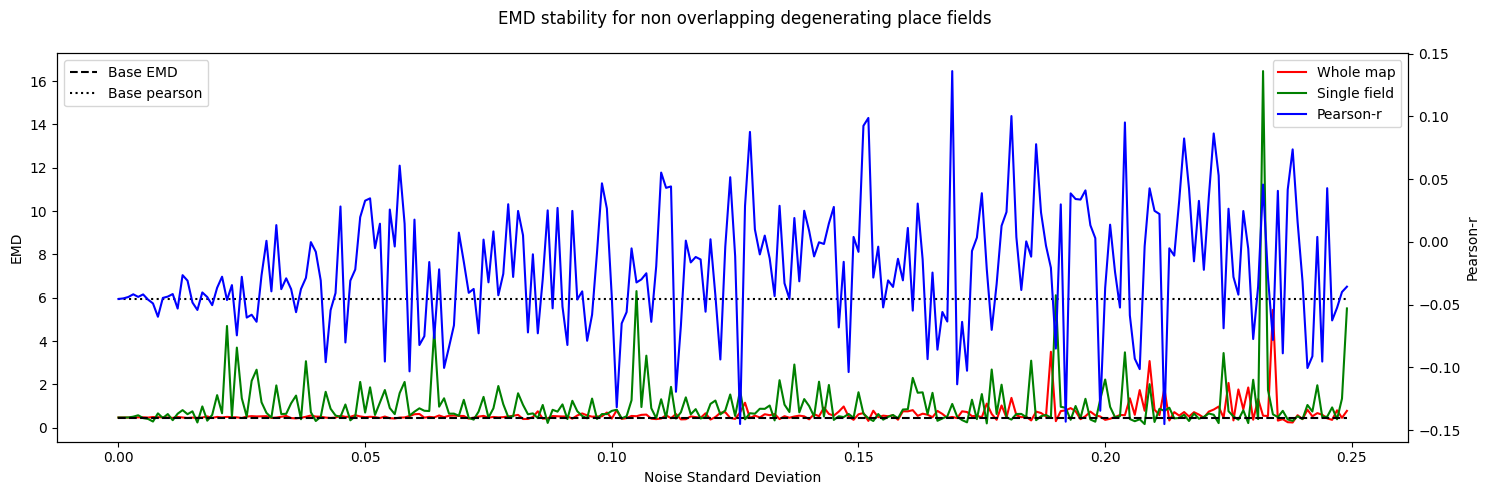

In [236]:

emd_field_scores[emd_field_scores != emd_field_scores] = 0
pearson_scores[pearson_scores != pearson_scores] = 0
emd_scores[emd_scores != emd_scores] = 0

emd_field_scores_std = np.std(emd_field_scores, axis=0)  
emd_scores_std = np.std(emd_scores, axis=0)  
pearson_scores_std = np.std(pearson_scores, axis=0)  

avg_emd_field_scores = np.mean(emd_field_scores,axis=0)
avg_emd_scores = np.mean(emd_scores, axis=0)
avg_pearson_scores = np.mean(pearson_scores, axis=0)

# avg_emd_scores = (avg_emd_scores - np.mean(avg_emd_scores)) / np.std(avg_emd_scores)
# avg_emd_field_scores = (avg_emd_field_scores - np.mean(avg_emd_field_scores)) / np.std(avg_emd_field_scores)
# avg_pearson_scores = (avg_pearson_scores - np.mean(avg_pearson_scores)) / np.std(avg_pearson_scores)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ln1 = ax.plot(np.arange(0,0.25,0.001), avg_emd_scores,color='r',label='Whole map')
ln2 = ax.plot(np.arange(0,0.25,0.001), avg_emd_field_scores,color='g',label='Single field')
ax.set_xlabel('Noise Standard Deviation')
ax.set_ylabel('EMD')
ln4 = ax.hlines(avg_emd_scores[0], 0, 0.25-0.001, color='k', linestyles = 'dashed', label='Base EMD')

axt = ax.twinx()
ln5 = axt.hlines(avg_pearson_scores[0], 0, 0.25-0.001, color='k', linestyles = 'dotted', label='Base pearson')
ln3 = axt.plot(np.arange(0,0.25,0.001), avg_pearson_scores,color='b',label='Pearson-r')
axt.set_ylabel('Pearson-r')

lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

lnst = [ln4, ln5]
labst = [l.get_label() for l in lnst]
axt.legend(lnst, labst,loc='upper left')

fig.suptitle('EMD stability for non overlapping degenerating place fields')
fig.tight_layout()
plt.show()

In [227]:
single_field = make_single_field(N, stdev)
left = single_field[N:N+N,N:N+N]
single_field = make_single_field(N, stdev, shift_row=0, shift_col=+ceil(N/10))
right = single_field[N:N+N,N:N+N]

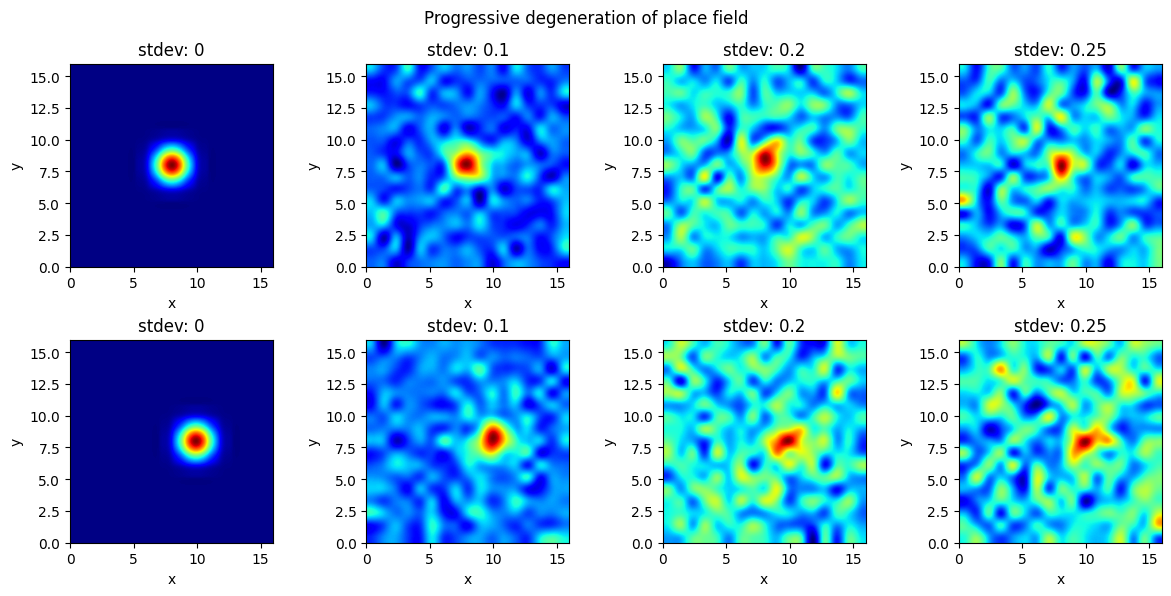

0


In [230]:
np.random.seed(0)
single_field = make_single_field(N, stdev)
left = single_field[N:N+N,N:N+N]
single_field = make_single_field(N, stdev, shift_row=0, shift_col=+ceil(N/10))
right = single_field[N:N+N,N:N+N]

use_plot = [0,0.1,0.2,0.25]

fig = plt.figure(figsize=(12,6))
for i in range(0,4,1):
    ax = plt.subplot(2,4,i+1)
    ax.imshow(_interpolate_matrix(left+np.random.normal(0,use_plot[i],(N,N))), cmap='jet', extent=[0,N-1,0,N-1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('stdev: ' + str(use_plot[i]))
for j in range(4,8,1):
    ax = plt.subplot(2,4,j+1)
    ax.imshow(_interpolate_matrix(right+np.random.normal(0,use_plot[j-4],(N,N))), cmap='jet', extent=[0,N-1,0,N-1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('stdev: ' + str(use_plot[j-4]))

fig.suptitle('Progressive degeneration of place field')
fig.tight_layout()
plt.show()

emd_scores = []
pearson_scores = []
emd_field_scores = []

n_repeat = 1
for j in range(n_repeat):
    print(j)
    rep_emd_scores = []
    rep_pearson_scores = []
    rep_emd_field_scores = []
    for i in np.arange(0,0.25,0.001):

        # source_field = left + np.random.normal(0,i,(N,N))
        # field = right + np.random.normal(0,i,(N,N))
            
        s_labels = []
        t_labels = []

        while ((1 in np.unique(t_labels)) and (1 in np.unique(s_labels))) == False:
            source_field = left + np.random.normal(0,i,(N,N))
            field = right + np.random.normal(0,i,(N,N))

            s_image, n_s, s_labels, _, _ = map_blobs(source_field)
            t_image, n_t, t_labels, _, _ = map_blobs(field)

        assert len(np.unique(t_labels)) != 1
        y, x = source_field.shape
        height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
        buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
        source_weights = np.array(list(map(lambda x: source_field[x[0],x[1]], buckets)))
        source_weights = source_weights / np.sum(source_weights)
        coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
        target_weights = np.array(list(map(lambda x: field[x[0],x[1]], buckets)))
        target_weights = target_weights / np.sum(target_weights)

        emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
        rep_emd_scores.append(emd)

        r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
        rep_pearson_scores.append(r)

        rows, cols = np.where(s_labels != 0)
        source_ids = np.array([rows, cols]).T
        source_weights = np.array(list(map(lambda x: source_field[x[0], x[1]], source_ids)))
        source_weights = source_weights / np.sum(source_weights)
        height_source_pts = height_bucket_midpoints[rows]
        width_source_pts = width_bucket_midpoints[cols]
        source_pts = np.array([height_source_pts, width_source_pts]).T

        rows, cols = np.where(t_labels != 0)
        target_ids = np.array([rows, cols]).T
        target_weights = np.array(list(map(lambda x: field[x[0], x[1]], target_ids)))
        target_weights = target_weights / np.sum(target_weights)
        height_target_pts = height_bucket_midpoints[rows]
        width_target_pts = width_bucket_midpoints[cols]
        target_pts = np.array([height_target_pts, width_target_pts]).T
                    
        emd = pot_sliced_wasserstein(source_pts, target_pts, source_weights, target_weights, n_projections=10**4)
        rep_emd_field_scores.append(emd)

        if emd > 5:
            plt.imshow(s_labels)
            plt.show()
            plt.imshow(t_labels)
            plt.show()
            plt.imshow(source_field)
            plt.show()
            plt.imshow(field)
            plt.show()

    emd_scores.append(rep_emd_scores)
    emd_field_scores.append(rep_emd_field_scores)
    pearson_scores.append(rep_pearson_scores)

emd_field_scores = np.array(emd_field_scores)
pearson_scores = np.array(pearson_scores)
emd_scores = np.array(emd_scores)


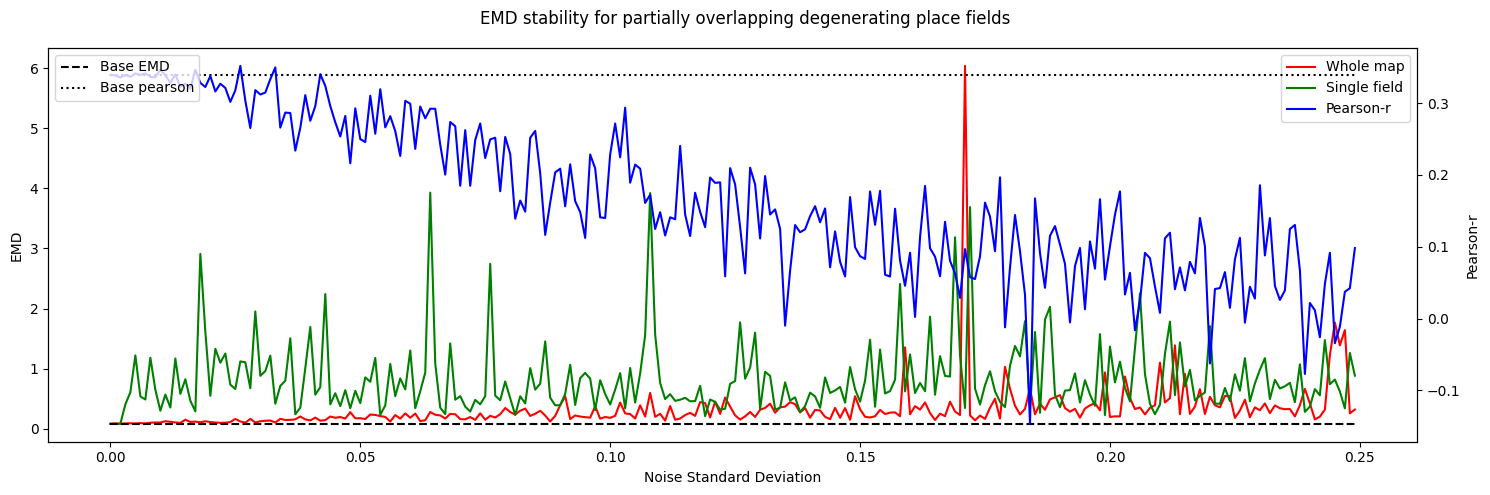

In [231]:

# emd_field_scores[emd_field_scores != emd_field_scores] = 0
pearson_scores[pearson_scores != pearson_scores] = 0
emd_scores[emd_scores != emd_scores] = 0

# emd_field_scores_std = np.std(emd_field_scores, axis=0)  
emd_scores_std = np.std(emd_scores, axis=0)  
pearson_scores_std = np.std(pearson_scores, axis=0)  

# avg_emd_field_scores = np.mean(emd_field_scores,axis=0)
avg_emd_scores = np.mean(emd_scores, axis=0)
avg_pearson_scores = np.mean(pearson_scores, axis=0)

# avg_emd_scores = (avg_emd_scores - np.mean(avg_emd_scores)) / np.std(avg_emd_scores)
# avg_emd_field_scores = (avg_emd_field_scores - np.mean(avg_emd_field_scores)) / np.std(avg_emd_field_scores)
# avg_pearson_scores = (avg_pearson_scores - np.mean(avg_pearson_scores)) / np.std(avg_pearson_scores)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ln1 = ax.plot(np.arange(0,0.25,0.001), avg_emd_scores,color='r',label='Whole map')
ln2 = ax.plot(np.arange(0,0.25,0.001), avg_emd_field_scores,color='g',label='Single field')
ax.set_xlabel('Noise Standard Deviation')
ax.set_ylabel('EMD')
ln4 = ax.hlines(avg_emd_scores[0], 0, 0.25-0.001, color='k', linestyles = 'dashed', label='Base EMD')

axt = ax.twinx()
ln5 = axt.hlines(avg_pearson_scores[0], 0, 0.25-0.001, color='k', linestyles = 'dotted', label='Base pearson')
ln3 = axt.plot(np.arange(0,0.25,0.001), avg_pearson_scores,color='b',label='Pearson-r')
axt.set_ylabel('Pearson-r')

lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

lnst = [ln4, ln5]
labst = [l.get_label() for l in lnst]
axt.legend(lnst, labst,loc='upper left')

fig.suptitle('EMD stability for partially overlapping degenerating place fields')
fig.tight_layout()
plt.show()